Konu: Website Phishing: Çeşitli web sitelerinden toplanan 9 özniteliğe göre 1353 web 
sitesinin kimlik avı-dolandırıcılık(pishing) tehditlerine göre Meşru:‘1’, Şüpheli: 
‘0’, Dolandırıcı(pishing):’-1’ sınıflandırılmıştır. 
Algoritma:  
LR(LogisticRegression: Lojistik regresyon tabanlı sınıflandırma) 
KNC(KNeighborsClassifier: K-en yakın komşular sınıflandırma) 

# Kütüphanelerin Eklenmesi 

In [462]:
import numpy as np #Bilimsel hesaplama için. Yani diziler, matrisler, matematiksel işlemler diyebiliriz.
import pandas as pd #veri analizi için
import matplotlib.pyplot as plt #görselleştirme için kullanacağız
from sklearn.model_selection import train_test_split #veriyi eğitim ve test verilerine ayırmamızı sağlayacak 
from sklearn.preprocessing import StandardScaler # veri ölçeklendirme yani normalizasyon işlemi için kullanacağız
from sklearn.linear_model import LogisticRegression # LR modelini oluşturmamız için bu kütüphaneyi eklememiz gerek.
from sklearn.neighbors import KNeighborsClassifier
#veri performans ölçmek için birden fazla yolu aşağıdaki komut ile ekliyoruz. Ör: f1 scoru gibi 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.io import arff #veri dosyasının yapısı yüzünden ilk seferde okuma işlemini gerçekleştiremedim

# Verinin Okunması 

- Veri dosyasını okuyup hakkında bilgi alarak başlayacağız. Ardından bu verileri kontrol edip ona göre hareket edeceğiz. 

In [463]:
#.arff dosyas okuma 
data_arff = arff.loadarff("data/PhishingData.arff")

#veri ile işlem yapabilmeye devam etmem için öncelikle pd ye uyumlu hale getirmeliyim 
data = pd.DataFrame(data_arff[0]) #[0] koymadığım için veriyi düzgünce çekemedim :) 

# Satır ve sütun sayısını kontrol et
print("Satır sayısı:", data.shape[0])
print("Sütun sayısı:", data.shape[1])

print("Veri Setinin Bir Kısmı: ")
print(data.head())

print("\nVeri Seti Hakkında Bilgi:")
print(data.info())

Satır sayısı: 1353
Sütun sayısı: 10
Veri Setinin Bir Kısmı: 
     SFH popUpWidnow SSLfinal_State Request_URL URL_of_Anchor web_traffic  \
0   b'1'       b'-1'           b'1'       b'-1'         b'-1'        b'1'   
1  b'-1'       b'-1'          b'-1'       b'-1'         b'-1'        b'0'   
2   b'1'       b'-1'           b'0'        b'0'         b'-1'        b'0'   
3   b'1'        b'0'           b'1'       b'-1'         b'-1'        b'0'   
4  b'-1'       b'-1'           b'1'       b'-1'          b'0'        b'0'   

  URL_Length age_of_domain having_IP_Address Result  
0       b'1'          b'1'              b'0'   b'0'  
1       b'1'          b'1'              b'1'   b'1'  
2      b'-1'          b'1'              b'0'   b'1'  
3       b'1'          b'1'              b'0'   b'0'  
4      b'-1'          b'1'              b'0'   b'1'  

Veri Seti Hakkında Bilgi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 10 columns):
 #   Column       

## Eksik Değer Kontrolü

In [464]:
print("\n Eksik Değer Kontrolü Yapalım:")
print(data.isnull().sum())

# Tamamen NaN olan sütunları kontrol et
nan_columns = data.columns[data.isnull().all()]
print("\nTamamen NaN olan sütunlar:", nan_columns) 


 Eksik Değer Kontrolü Yapalım:
SFH                  0
popUpWidnow          0
SSLfinal_State       0
Request_URL          0
URL_of_Anchor        0
web_traffic          0
URL_Length           0
age_of_domain        0
having_IP_Address    0
Result               0
dtype: int64

Tamamen NaN olan sütunlar: Index([], dtype='object')


- Çıktıya göre boş sütun yok o yüzden kaldırmamız gereken bir sütunda yok demektir. Olsaydı duruma el atmamız lazımdı şekerim <3 

* Çıktı yorumlarsak veri setindeki veriler object türünde. Eksik verileri tamamlamak istediğimizde veri türlerini değiştirmemiz gerekecek yoksa bu kısım ileride hata almamıza sebep olacak. 
- Eksik değer kontrolünde ilk satırlarda eksik değer gözükmüyor fakat sonraki 1348. satırdan itibaren satırlarda eksik görünmeye başlanmış ve bu 1 ile ifade edilmiş. Eksik satırlar doldurulmalı ki model düşük performans ile çalışmasın. 

## Veri Sayısallaştırma

In [465]:
# Object Türündeki sütunları listeleyip bir diziye atayacağım. Ardından dönüşüm yapacağım
non_numeric_columns = data.select_dtypes(include=['object']).columns

# Object türündeki sütunlarda temizleme işlemi
for col in non_numeric_columns:
    data[col] = data[col].apply(lambda x: x.decode('utf-8')).astype(float)  # Başındaki ve sonundaki boşlukları temizle
    
# Sayısallaştırma işlemi
data = data.apply(pd.to_numeric, errors='coerce')

print("\nVeri Türleri:")
print(data.dtypes)


Veri Türleri:
SFH                  float64
popUpWidnow          float64
SSLfinal_State       float64
Request_URL          float64
URL_of_Anchor        float64
web_traffic          float64
URL_Length           float64
age_of_domain        float64
having_IP_Address    float64
Result               float64
dtype: object


## Eksik Veri Tamamlama 

In [466]:
#eksik değerleri 0 ile dolduralım. Çünkü ne suçlu ne meşru diyebiliriz. 0 şüpheli iyidir :)
# ilk denemem de fillna('0') olarak yazdığım için sayısallaştırma işlemi yine tersine döndü :D 
data = data.fillna(0) 

#sonrasında bir kez daha değerleri kontrol edelim 
print("\n Doldurma İşleminden Sonra Eksik Değer Kontrolü:")
print(data.isnull().sum())

print(data.columns)


 Doldurma İşleminden Sonra Eksik Değer Kontrolü:
SFH                  0
popUpWidnow          0
SSLfinal_State       0
Request_URL          0
URL_of_Anchor        0
web_traffic          0
URL_Length           0
age_of_domain        0
having_IP_Address    0
Result               0
dtype: int64
Index(['SFH', 'popUpWidnow', 'SSLfinal_State', 'Request_URL', 'URL_of_Anchor',
       'web_traffic', 'URL_Length', 'age_of_domain', 'having_IP_Address',
       'Result'],
      dtype='object')


# Önişlem Yapılması

In [467]:
x = data.iloc[:, :-1] #son sütun hariç tüm sütunlar
y = data.iloc[:, -1] #son sütun 

print("Veri seti boyutu:", data.shape)
print("\n x:", x.shape)
print("\n y", y.shape)

Veri seti boyutu: (1353, 10)

 x: (1353, 9)

 y (1353,)


# Eğitim ve Test Verilerine Ayrılması 

In [468]:
#veriyi eğitim ve test verileri olmak üzere iki kısma böleceğiz. 
#genelde bunun için 0.2 veya 0.3 kullanılır
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#Şimdi verileri kontrol edelim
print("\nEğitim Verileri:", x_train.shape, x_test.shape)
print("\nTest Verileri:", y_train.shape, y_test.shape)


Eğitim Verileri: (947, 9) (406, 9)

Test Verileri: (947,) (406,)


# Veri Ölçeklendirme 

- Normalizasyon işlemi yapacağız

In [469]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# LR Modeli Oluşturma

- Bu modeli kullanmak için bir kütüphane eklemiştik zaten. Bunu bize scikit-learn kütüphenesi sağladı. O yüzden biz ondan faydalanacağız sadece.

- Model hiperparametre optimizasyonundan önce %84 performans gösteriyordu. Bu performansı arttıracak diye umuyorum. 

In [470]:
LR_model = LogisticRegression()
LR_model.fit(x_train_scaled, y_train)

LogisticRegression()

# KNC Modeli Oluşturma 

In [471]:
#KNC modeli
knc_model = KNeighborsClassifier()
knc_model.fit(x_train_scaled, y_train)

KNeighborsClassifier()

# Tahminlerin Yapılması

- Tahmin yapacağız ve sonrasında model performansını değerlendirmek için birkaç metrik kullanacağız. 

In [472]:
y_pred_train_lr = LR_model.predict(x_train_scaled)
y_pred_test_lr = LR_model.predict(x_test_scaled)

In [473]:
y_pred_test_knc = knc_model.predict(x_test_scaled)

# Sonuçların Sunumu

- Modelin ne kadar iyi çalıştığını kontrol edelim. Bu bize model hakkında bir fikir verecek. LR: 

In [474]:
print("LR Test Performansı:")

print(classification_report(y_test, y_pred_test_lr))

print("\nSkor:", accuracy_score(y_test, y_pred_test_lr))

LR Test Performansı:
              precision    recall  f1-score   support

        -1.0       0.83      0.95      0.89       203
         0.0       0.57      0.11      0.19        35
         1.0       0.86      0.87      0.87       168

    accuracy                           0.84       406
   macro avg       0.76      0.64      0.65       406
weighted avg       0.82      0.84      0.82       406


Skor: 0.8423645320197044


- KNC:

In [475]:
print("KNC Test Performansı:")
print(classification_report(y_test, y_pred_test_knc))

#Doğruluk skoru görelim
print("\nKNC Test Doğruluk Skoru:", accuracy_score(y_test, y_pred_test_knc))

KNC Test Performansı:
              precision    recall  f1-score   support

        -1.0       0.88      0.92      0.90       203
         0.0       0.75      0.34      0.47        35
         1.0       0.82      0.86      0.84       168

    accuracy                           0.85       406
   macro avg       0.82      0.71      0.74       406
weighted avg       0.84      0.85      0.84       406


KNC Test Doğruluk Skoru: 0.8472906403940886


# Görselleştirme - LR için

## Karışıklık Matrisinin Görselleştirmesi

- LR ---> Görselleiştirme yapmak için önce bir matris oluşturuyoruz. 

In [476]:
cm = confusion_matrix(y_test, y_pred_test_lr, labels=LR_model.classes_)
print("\nKarışıklık Matrisi:\n", cm)


Karışıklık Matrisi:
 [[192   3   8]
 [ 16   4  15]
 [ 22   0 146]]


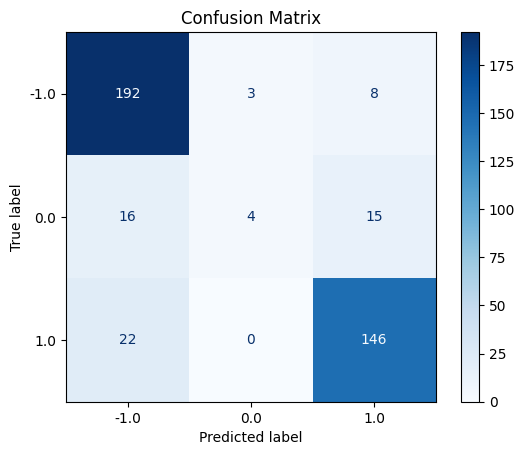

In [477]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## ROC Eğrisinin Çizdirilmesi

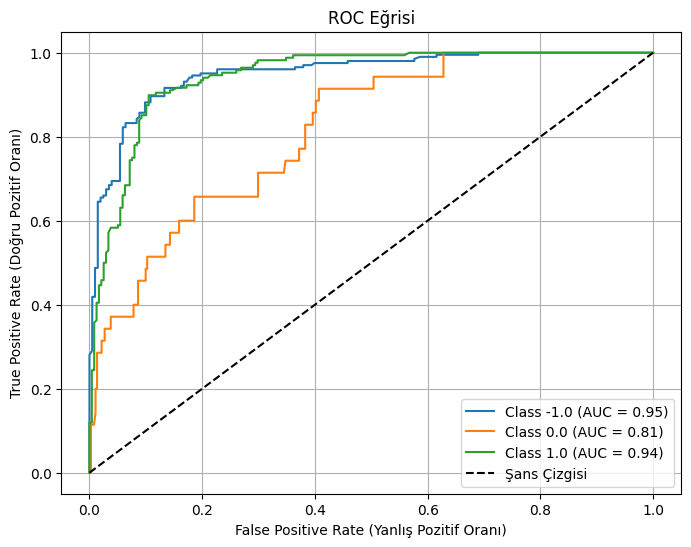

In [478]:
y_proba = LR_model.predict_proba(x_test_scaled)
y_test_binarized = label_binarize(y_test, classes=LR_model.classes_)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(LR_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrisi çizimi
plt.figure(figsize=(8, 6))
for i in range(len(LR_model.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Class {LR_model.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Şans Çizgisi")
plt.xlabel("False Positive Rate (Yanlış Pozitif Oranı)")
plt.ylabel("True Positive Rate (Doğru Pozitif Oranı)")
plt.title("ROC Eğrisi")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Görselleştirme KNC için

## Confusion Matrix 

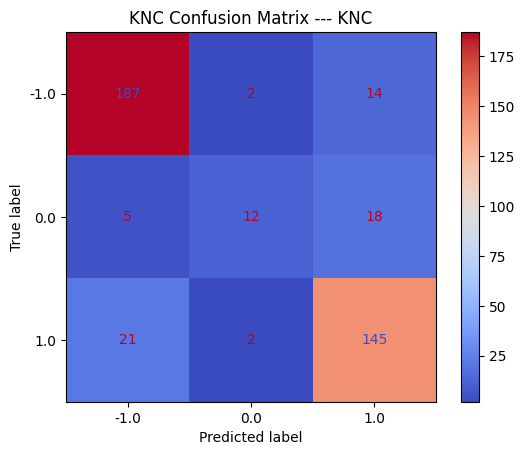

In [479]:
cm_knc = confusion_matrix(y_test, y_pred_test_knc, labels=knc_model.classes_)
disp_knc = ConfusionMatrixDisplay(confusion_matrix=cm_knc, display_labels=knc_model.classes_)
disp_knc.plot(cmap=plt.cm.coolwarm)
plt.title("KNC Confusion Matrix --- KNC")
plt.show()

## ROC Eğrisi ve AUC Skoru

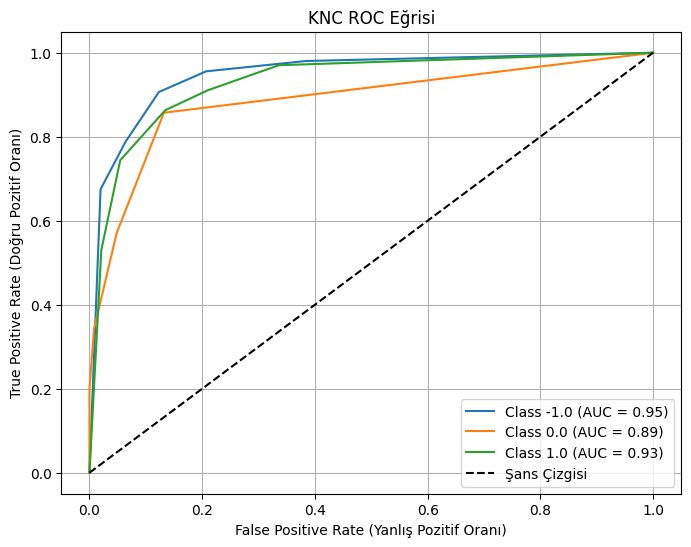

In [480]:
y_proba_knc = knc_model.predict_proba(x_test_scaled) #tahmin olasılıklarını alıyoruz

#ikili sisteme çevirelim
y_test_binarized = label_binarize(y_test, classes=knc_model.classes_)
fpr_knc, tpr_knc, roc_auc_knc = {}, {}, {}

for i in range(len(knc_model.classes_)):
    fpr_knc[i], tpr_knc[i], _ = roc_curve(y_test_binarized[:, i], y_proba_knc[:, i])
    roc_auc_knc[i] = auc(fpr_knc[i], tpr_knc[i])

# ROC eğrisi çizimi
plt.figure(figsize=(8, 6))
for i in range(len(knc_model.classes_)):
    plt.plot(fpr_knc[i], tpr_knc[i], label=f"Class {knc_model.classes_[i]} (AUC = {roc_auc_knc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Şans Çizgisi")
plt.xlabel("False Positive Rate (Yanlış Pozitif Oranı)")
plt.ylabel("True Positive Rate (Doğru Pozitif Oranı)")
plt.title("KNC ROC Eğrisi")
plt.legend(loc="lower right")
plt.grid()
plt.show()
